In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')
!pip install hydroeval
import hydroeval as he
# Set seeds for all major libraries
import os
import glob
import seaborn as sns
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Current time: 2025-06-24 04:27:30.909966
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [3]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
  "13190500"
 #"13311450",


 #"13304050"


]
print(type(model_site[0]))
lstm_file_paths = glob.glob('/content/drive/MyDrive/LSTM_results/best_KGE/best_KGE_result_*.csv', recursive=True)
lstm_file_names = [os.path.basename(path) for path in lstm_file_paths]
lstm_file_names.sort()
#for name in lstm_file_names:
    #print(name)
#print(lstm_file_names[-1])
lstm_csv_path = '/content/drive/MyDrive/LSTM_results/best_KGE/' + lstm_file_names[-1]
lstm = pd.read_csv( lstm_csv_path)
#lstm['model_site'] = lstm['model_site'].astype('Int64')
print(type(lstm['model_site']))
lstm['model_site'] = lstm['model_site'].astype(str)
print( lstm[lstm['model_site']==model_site[0]])
#print(lstm)

<class 'str'>
<class 'pandas.core.series.Series'>
   Unnamed: 0                current_time model_site         train_month   h1  \
6          80  2025-06-13 17:30:30.756569   13190500  [3, 4, 5, 6, 7, 8]  256   

    h2   d1    d2  batch  look_back  ... learning_rate        r2      rmse  \
6  100  0.2  0.05      8         45  ...        0.0001  0.599949  0.906436   

       bias  std_ratio  correlation           KGE    KGE_r_comp  \
6 -0.179885   1.042637     0.813672  [0.80698408]  [0.81367243]   

  KGE_alpha_comp KGE_beta_comp  
6   [1.04263729]  [0.97318127]  

[1 rows x 21 columns]


In [4]:


units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )

dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year


dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]


shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))


print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print("df_cleaned:",df_cleaned)

# Print the cleaned DataFrame
print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

# gap

# Calculate time difference between consecutive dates
df_cleaned['Gap'] = df_cleaned['Date'].diff()

# Filter rows where the gap is more than expected (e.g., > 1 day)
expected_freq = pd.Timedelta(days=1)
gaps = df_cleaned[df_cleaned['Gap'] > expected_freq]

print("gaps",gaps)


site_info_df:   agency_cd   site_no                               station_nm site_tp_cd  \
0      USGS  13190500  SF BOISE RIVER AT ANDERSON RANCH DAM ID         ST   

   lat_va  long_va  dec_lat_va  dec_long_va coord_meth_cd coord_acy_cd  ...  \
0  432037  1152839   43.343611    -115.4775             G            S  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0            NaN   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                    geometry  
0           NaN          NaN         NaN  POINT (-115.4775 43.34361)  

[1 rows x 43 columns]
station_nm: SF BOISE RIVER AT ANDERSON RANCH DAM ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:            tmean   site_no       Date  00010_Mean  00060_Mean
8918   -1.199000  13190500 2020-03-01         4.0       305.0
8919   -1.367000  13190500 2020-03-02         4.1       299.0
8920    3.940400  13190500 2020-03-03         4.4       302.0


/tmp/ipython-input-4-2260655170.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [5]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [6]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#  the minimum of feature is made equal to zero and the maximum of feature equal to one.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
#print(df.head())
print(df.tail())
#print(df.shape)

(920, 6)
(920, 6)

DataFrame after Normalization Head:
          tmean   site_no       Date  00010_Mean  00060_Mean    Gap
10558  0.722937  13190500 2024-08-27    0.744186    0.048342 1 days
10559  0.607814  13190500 2024-08-28    0.720930    0.042626 1 days
10560  0.641404  13190500 2024-08-29    0.709302    0.042789 1 days
10561  0.737673  13190500 2024-08-30    0.732558    0.042300 1 days
10562  0.842329  13190500 2024-08-31    0.732558    0.042300 1 days


/tmp/ipython-input-7-46837385.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['Date'] = pd.to_datetime(df_12['Date'])


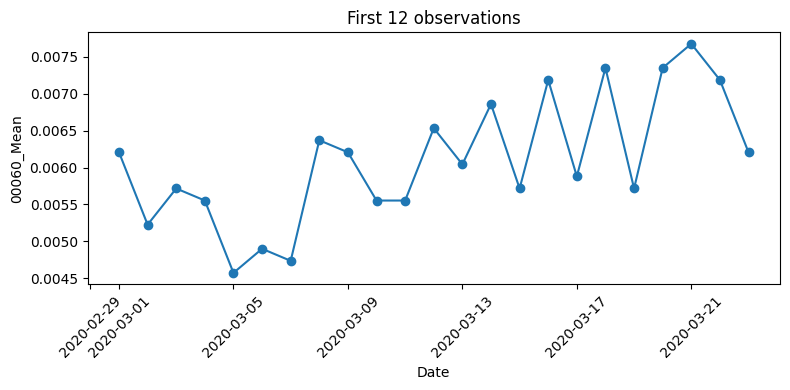

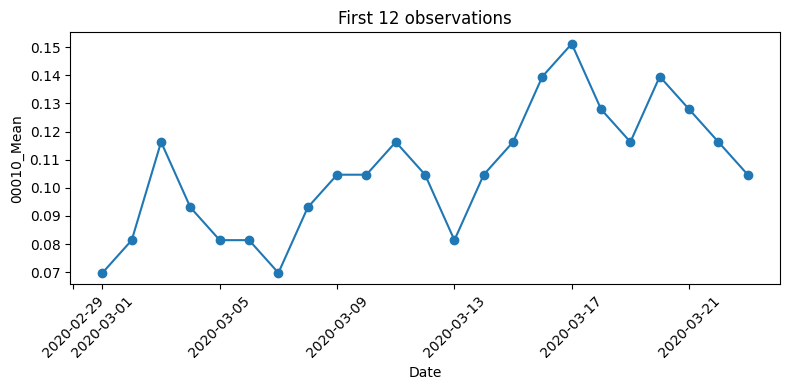

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your full DataFrame is called `df`
# 1) Keep only the first 12 rows
df_12 = df.head(23)        # or df.iloc[:12]

# 2) Make sure 'Date' is datetime (skip if it already is)
df_12['Date'] = pd.to_datetime(df_12['Date'])

# 3) Plot
plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00060_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00060_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00010_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00010_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back =  21 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.19632916 0.00620611 0.06976744]
 [0.19166214 0.0052262  0.08139535]
 [0.33910138 0.00571615 0.11627907]
 ...
 [0.64140402 0.04278948 0.70930233]
 [0.73767264 0.04229953 0.73255814]
 [0.84232937 0.04229953 0.73255814]]
X [[[0.19632916 0.00620611]
  [0.19166214 0.0052262 ]
  [0.33910138 0.00571615]
  ...
  [0.37907671 0.00734934]
  [0.35417477 0.00767598]
  [0.34109043 0.00718602]]

 [[0.19166214 0.0052262 ]
  [0.33910138 0.00571615]
  [0.30857123 0.00555283]
  ...
  [0.35417477 0.00767598]
  [0.34109043 0.00718602]
  [0.35525541 0.00620611]]

 [[0.33910138 0.00571615]
  [0.30857123 0.00555283]
  [0.33729846 0.00457292]
  ...
  [0.34109043 0.00718602]
  [0.35525541 0.00620611]
  [0.2867223  0.00636943]]

 ...

 [[0.86396579 0.15564266]
  [0.88948863 0.15400947]
  [0.83548029 0.15237629]
  ...
  [0.7229368  0.04834232]
  [0.60781396 0.04262616]
  [0.64140402 0.04278948]]

 [[0.88948863 0.15400947]
  [0.83548029 0.15237629]
  [0.83001176 0.1507431 ]
  ...
  [0.60781396 0.04262

In [9]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")


print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")


print(f"Y Test samples: {len(Y_test)}")

Train samples: 719
Test samples: 180
 Y Train samples: 719
Y Test samples: 180


In [10]:
print("X_train[0]:", X_train[0])
print("Y_train[0]:", Y_train[0])


print("df.head(6)",df.head(6))
#print("X:", X)
#print("Y:", Y)


#print("X_train:", X_train)
#print("Y_train:", Y_train)
print("Y_train.shape:", Y_train.shape)
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)

X_train[0]: [[0.19632916 0.00620611]
 [0.19166214 0.0052262 ]
 [0.33910138 0.00571615]
 [0.30857123 0.00555283]
 [0.33729846 0.00457292]
 [0.42003823 0.00489956]
 [0.33577056 0.00473624]
 [0.28569722 0.00636943]
 [0.28644451 0.00620611]
 [0.32450302 0.00555283]
 [0.33893748 0.00555283]
 [0.25415311 0.00653275]
 [0.22995678 0.00604279]
 [0.33612893 0.00685938]
 [0.3363095  0.00571615]
 [0.36481171 0.00718602]
 [0.36856478 0.00587947]
 [0.26923484 0.00734934]
 [0.32019713 0.00571615]
 [0.37907671 0.00734934]
 [0.35417477 0.00767598]
 [0.34109043 0.00718602]]
Y_train[0]: 0.1162790697674419
df.head(6)          tmean   site_no       Date  00010_Mean  00060_Mean    Gap
8918  0.196329  13190500 2020-03-01    0.069767    0.006206    NaT
8919  0.191662  13190500 2020-03-02    0.081395    0.005226 1 days
8920  0.339101  13190500 2020-03-03    0.116279    0.005716 1 days
8921  0.308571  13190500 2020-03-04    0.093023    0.005553 1 days
8922  0.337298  13190500 2020-03-05    0.081395    0.004573 

/tmp/ipython-input-11-2831626437.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([array1, array2],


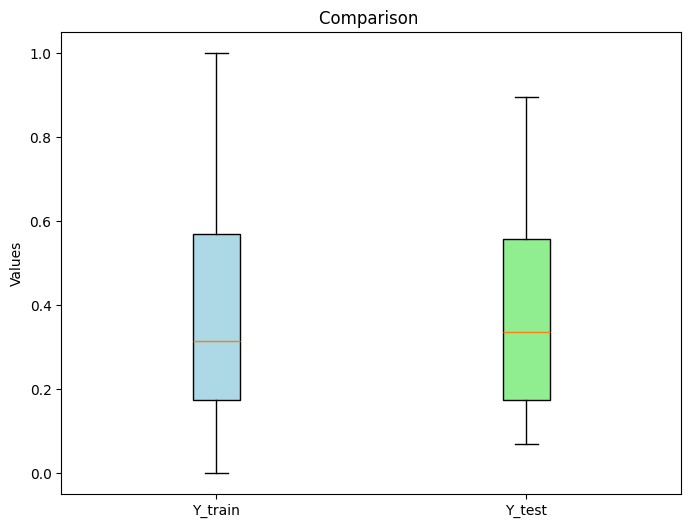

Number of zeros Y_train: 3


In [11]:


import matplotlib.pyplot as plt
import numpy as np  # Only needed if you're creating example data

# Example data (replace with your actual arrays)
array1 = Y_train
array2 =  Y_test

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create the boxplot
boxplot = plt.boxplot([array1, array2],
                     patch_artist=True,
                     labels=['Y_train', 'Y_test'])

# Customize colors (optional)
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title('Comparison ')
plt.ylabel('Values')

# Show the plot
plt.show()

num_zeros = Y_train.size - np.count_nonzero(Y_train)

print(f"Number of zeros Y_train: {num_zeros}")

In [12]:
model_params = {
    'h1': 256,
    'h2': 128,
   # 'learning_rate': 0.0001,
   'dropout_rate_1': 0.1,
   'dropout_rate_2': 0.05,
   # 'loss_function': 'mean_squared_error',


}

h1 = model_params['h1']
h2 = model_params['h2']
#learning_rate = model_params['learning_rate']
d1 = model_params['dropout_rate_1']
d2 = model_params['dropout_rate_2']


In [13]:
# --- 5. Build LSTM Model ---


learning_rate = 0.0001
optimizer= Adam(learning_rate= learning_rate ) #'adam'
#Adadelta(learning_rate=learning_rate)
#d1 = 0.1
#d2 = 0.1

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,465 (1.76 MB)

 Trainable params: 462,465 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x7de2ea5af600>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x7de2ea5af600>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x7de2ea5afc40>


Epoch 1/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0389 - val_loss: 0.0364
Epoch 2/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0206 - val_loss: 0.0346
Epoch 3/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0190 - val_loss: 0.0389
Epoch 4/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0187 - val_loss: 0.0418
Epoch 5/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0181 - val_loss: 0.0442
Epoch 6/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0173 - val_loss: 0.0441
Epoch 7/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0171 - val_loss: 0.0452
Epoch 8/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0177 - val_loss: 0.0477
Epoch 9/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0173 - val_loss: 0.0458
Epoch 10/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170 - val_loss: 0.0492
Epoch 11/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0169 - val_loss: 0.0471
Epoch 12/105
144/144 ━━━━━━━━━━━━━━━━━━━

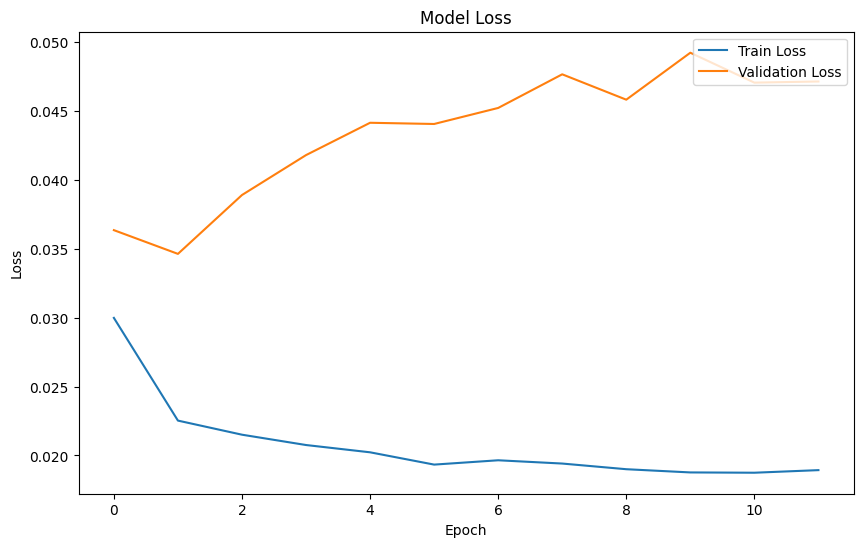

In [14]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  4
history = model.fit(X_train, Y_train,
                    epochs=105, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

#print(history)
# Print the epoch the model stopped at
print(f"Training stopped at epoch: {len(history.history['loss'])}")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,397 (5.29 MB)

 Trainable params: 462,465 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 924,932 (3.53 MB)

In [16]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0236
Test Loss (MSE): 0.0191


In [17]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Shape of Y_pred_scaled: (180, 1)
Shape of Y_test: (180,)
Shape of X_test: (180, 22, 2)
Test RMSE: 1.1884
Test bias: -0.4617
correlation 0.8056176701012987
1.4292457
1.845763918935584


In [18]:



# Example arrays
x = np.array([1, 2, 3, 4, 5])
print(x.shape)
y = np.array([2, 4, 6, 8, 10])

# Compute the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient (Pearson's r)
correlation_example = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_example)


print("Y_test_original",Y_test_original.shape)
print("Y_test_original",type(Y_test_original) )
print(np.isnan(Y_test_original).sum())
print(np.isinf(Y_test_original).sum())
print("Y_pred",Y_pred.shape)
print("Y_pred",type(Y_pred))
print(np.isnan(Y_pred).sum())
print(np.isinf(Y_pred).sum())

(5,)
Correlation coefficient: 0.9999999999999999
Y_test_original (180, 1)
Y_test_original <class 'numpy.ndarray'>
0
0
Y_pred (180, 1)
Y_pred <class 'numpy.ndarray'>
0
0


In [19]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print("summer_df.tail()",summer_df.tail())
# df.to_csv('/content/drive/My Drive/your_dataframe.csv', index=False)
summer_df.to_csv( '/content/drive/My Drive/LSTM_predictions/'+( model_site[0] + "summer_df.csv") , index=False )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of           tmean   site_no       Date  00010_Mean  00060_Mean    Gap
8918   0.196329  13190500 2020-03-01    0.069767    0.006206    NaT
8919   0.191662  13190500 2020-03-02    0.081395    0.005226 1 days
8920   0.339101  13190500 2020-03-03    0.116279    0.005716 1 days
8921   0.308571  13190500 2020-03-04    0.093023    0.005553 1 days
8922   0.337298  13190500 2020-03-05    0.081395    0.004573 1 days
...         ...       ...        ...         ...         ...    ...
10558  0.722937  13190500 2024-08-27    0.744186    0.048342 1 days
10559  0.607814  13190500 2024-08-28    0.720930    0.042626 1 days
10560  0.641404  13190500 2024-08-29    0.709302    0.042789 1 days
10561  0.737673  13190500 2024-08-30    0.732558    0.042300 1 days
10562  0.842329  13190500 2024-08-31    0.732558    0.042300 1 days

[920 rows x 6 columns]>
719
899
dt_ys.tail()           tmean   site_no       Date  00010_Mean  00060_Mean    Gap    Y_pred  \
10558  0.7

/tmp/ipython-input-19-2810182290.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
/tmp/ipython-input-19-2810182290.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
/tmp/ipython-input-19-2810182290.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

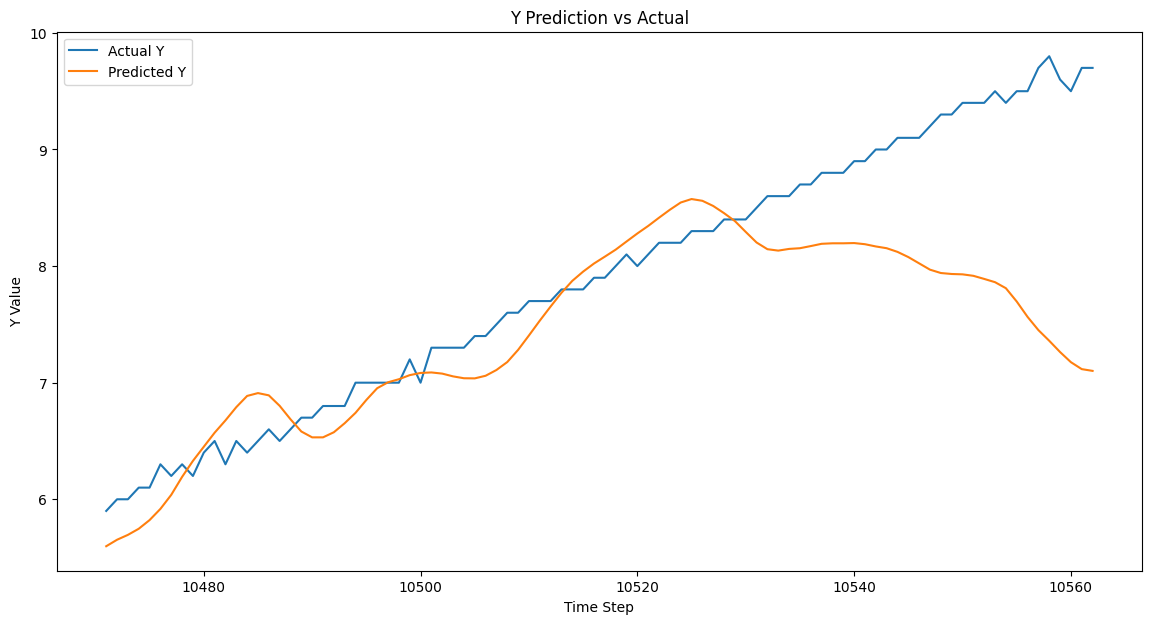

In [20]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

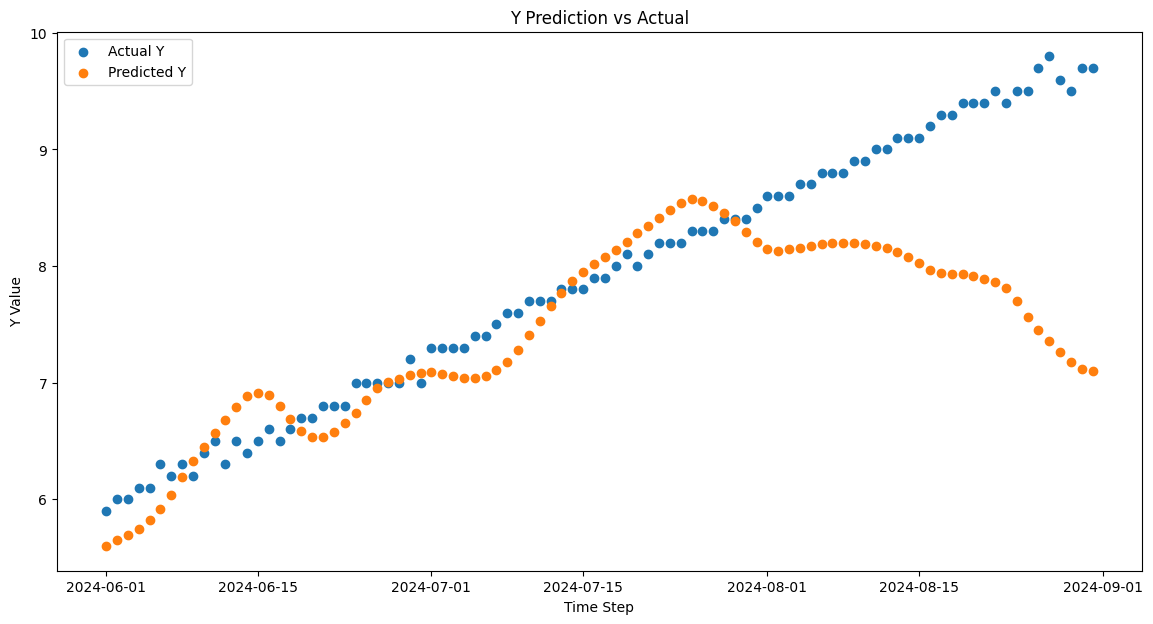

In [21]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

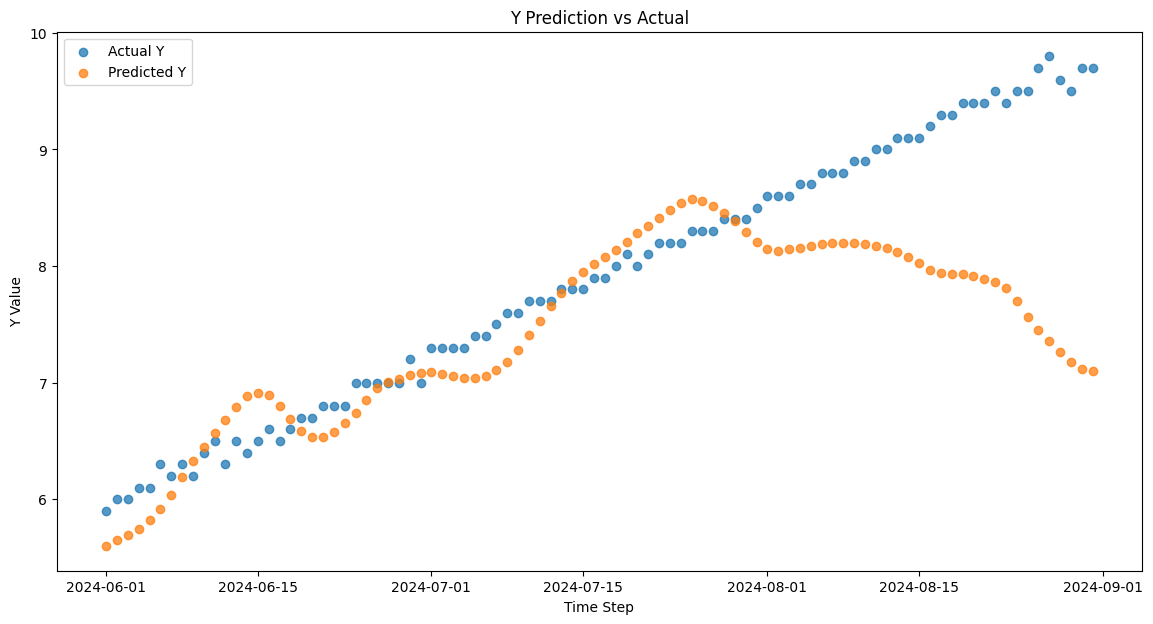

In [22]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

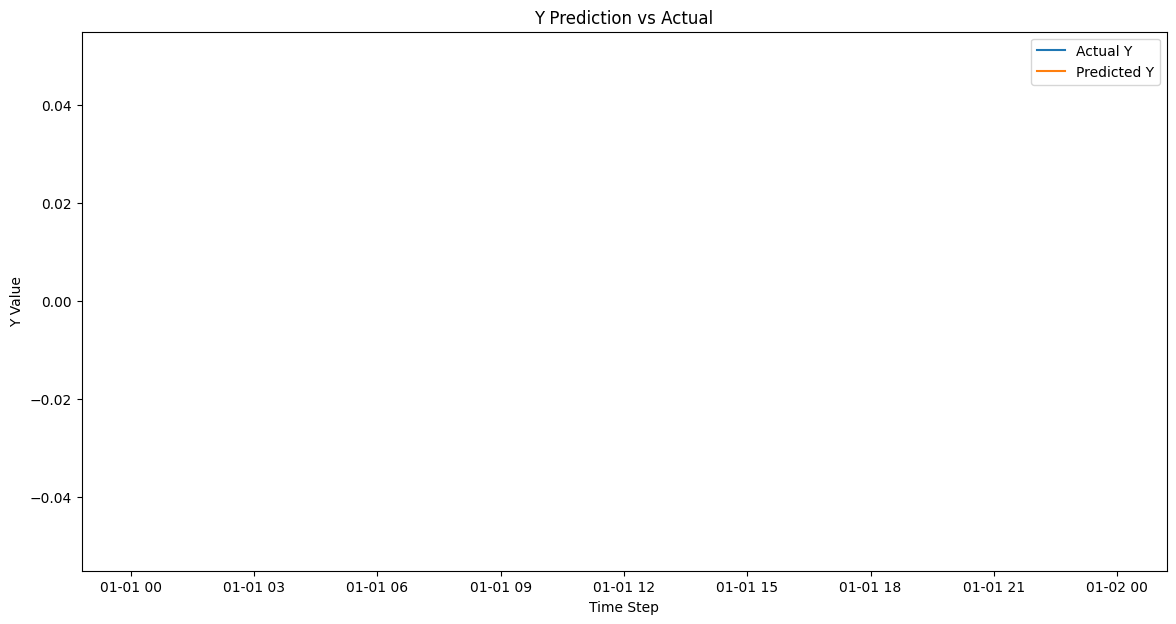

In [23]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

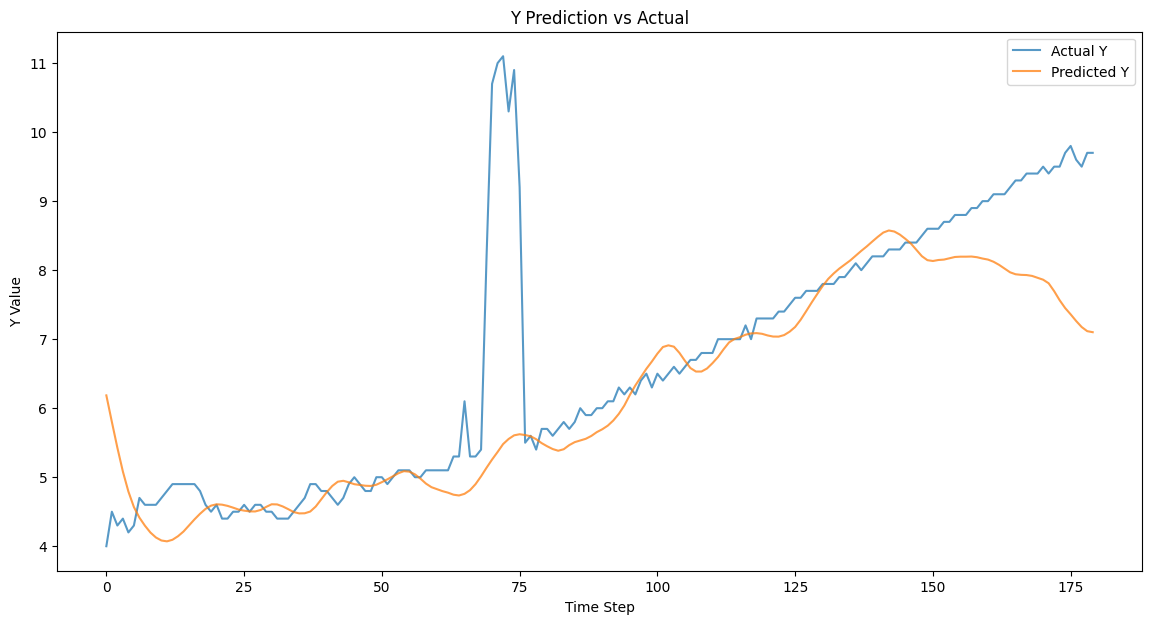

In [24]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()


In [25]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
    ,"r2" :[r2]
    , "rmse":[rmse]
                           , "bias":[bias]

                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]


    ,"KGE" : [kge_value]
,"KGE_r_comp" : [r_comp]
,"KGE_alpha_comp" : [alpha_comp]
,"KGE_beta_comp" : [beta_comp]
    })

print(result_df)


result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_results/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


                current_time model_site         train_month   h1   h2   d1  \
0 2025-06-24 04:27:30.909966   13190500  [3, 4, 5, 6, 7, 8]  256  128  0.1   

     d2  batch  look_back                                          optimizer  \
0  0.05      4         21  <keras.src.optimizers.adam.Adam object at 0x7d...   

   learning_rate        r2      rmse      bias  std_ratio  correlation  \
0         0.0001  0.585465  0.877967 -0.461724   0.774338     0.805618   

                    KGE            KGE_r_comp        KGE_alpha_comp  \
0  [0.6941519175727667]  [0.8056176701012989]  [0.7743383082258661]   

          KGE_beta_comp  
0  [0.9304632455948364]  


In [26]:
#model.save( (model_site[0]+'_lstm_model.h5') )

          tmean   site_no       Date  00010_Mean  00060_Mean    Gap    Y_pred  \
10471  0.629823  13190500 2024-06-01    0.290698    0.283031 1 days  5.597387   
10472  0.657858  13190500 2024-06-02    0.302326    0.283031 1 days  5.652981   
10473  0.546712  13190500 2024-06-03    0.302326    0.284664 1 days  5.694750   
10474  0.625789  13190500 2024-06-04    0.313953    0.284664 1 days  5.747180   
10475  0.703251  13190500 2024-06-05    0.313953    0.284664 1 days  5.821530   

       Y_test_original      bias  
10471              5.9 -0.302613  
10472              6.0 -0.347019  
10473              6.0 -0.305250  
10474              6.1 -0.352820  
10475              6.1 -0.278470  


/tmp/ipython-input-27-2963098943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


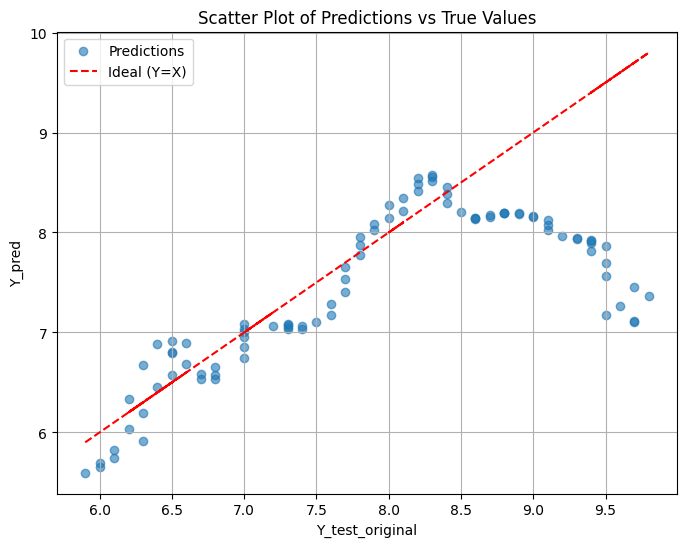

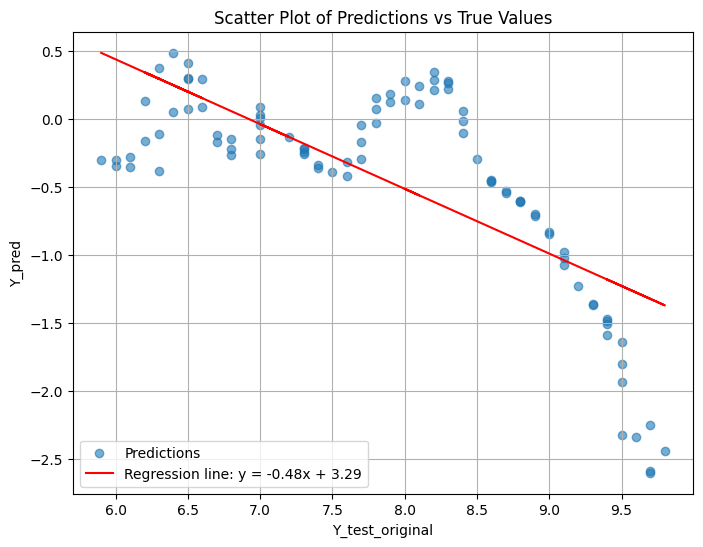

In [27]:
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']
print( summer_df.head() )

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

Locates the peak bias

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, 10471 to 10562
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   tmean            92 non-null     float64        
 1   site_no          92 non-null     object         
 2   Date             92 non-null     datetime64[ns] 
 3   00010_Mean       92 non-null     float64        
 4   00060_Mean       92 non-null     float64        
 5   Gap              92 non-null     timedelta64[ns]
 6   Y_pred           92 non-null     float32        
 7   Y_test_original  92 non-null     float64        
 8   bias             92 non-null     float64        
dtypes: datetime64[ns](1), float32(1), float64(5), object(1), timedelta64[ns](1)
memory usage: 6.8+ KB
None
          tmean   site_no       Date  00010_Mean  00060_Mean    Gap    Y_pred  \
10471  0.629823  13190500 2024-06-01    0.290698    0.283031 1 days  5.597387   
10472  0.657858  13190500 2024-0

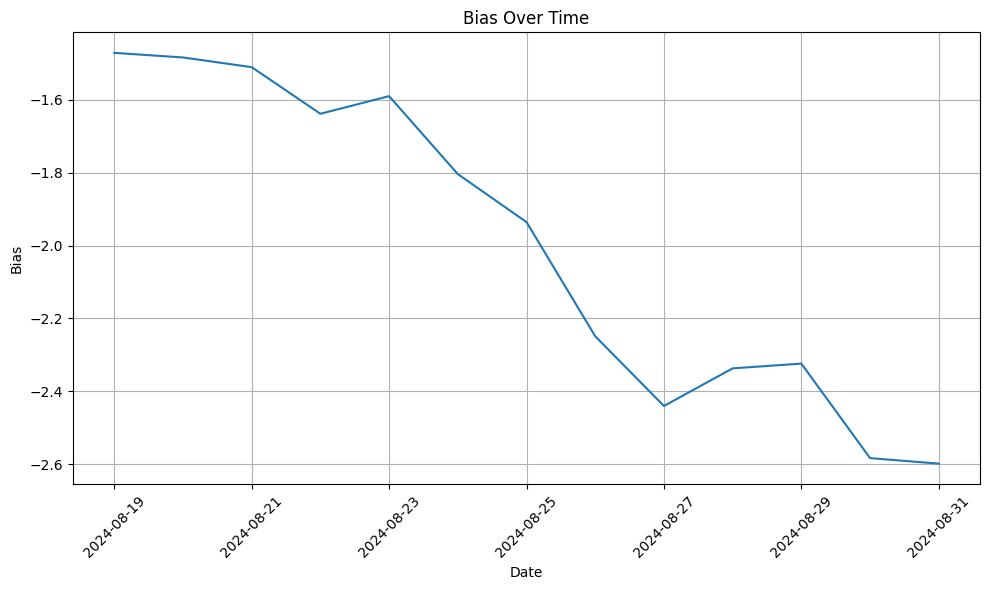

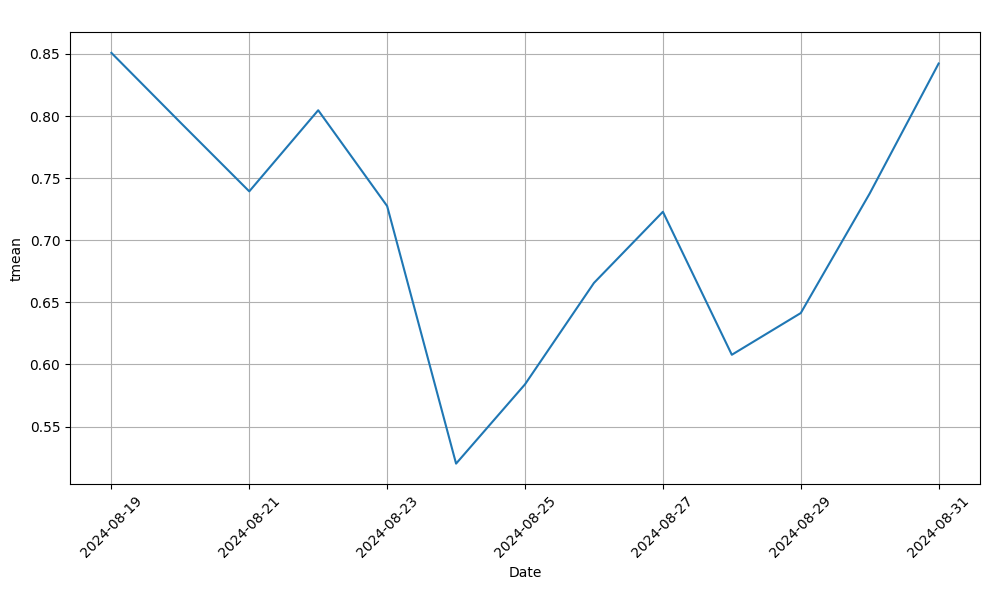

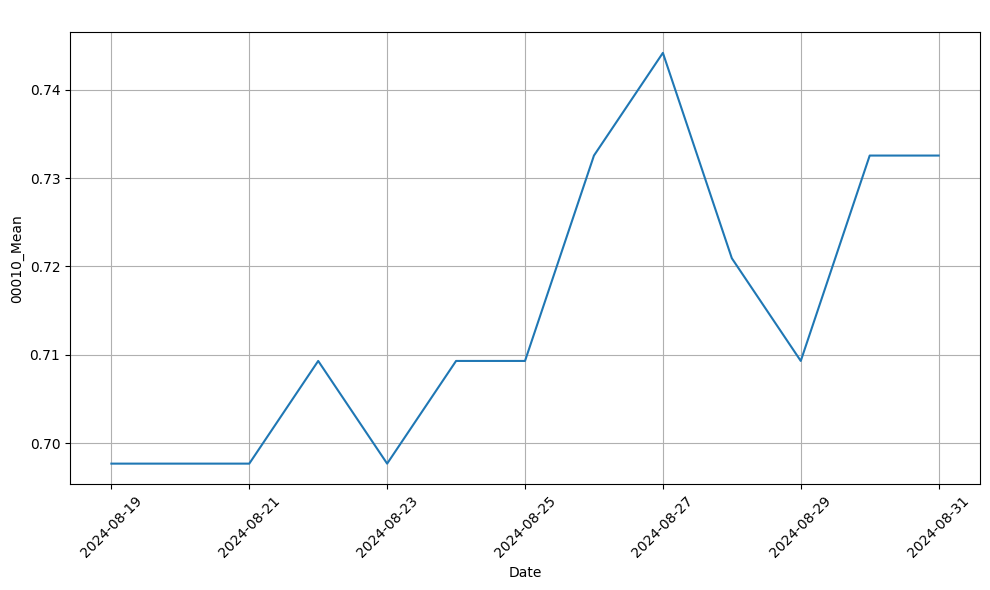

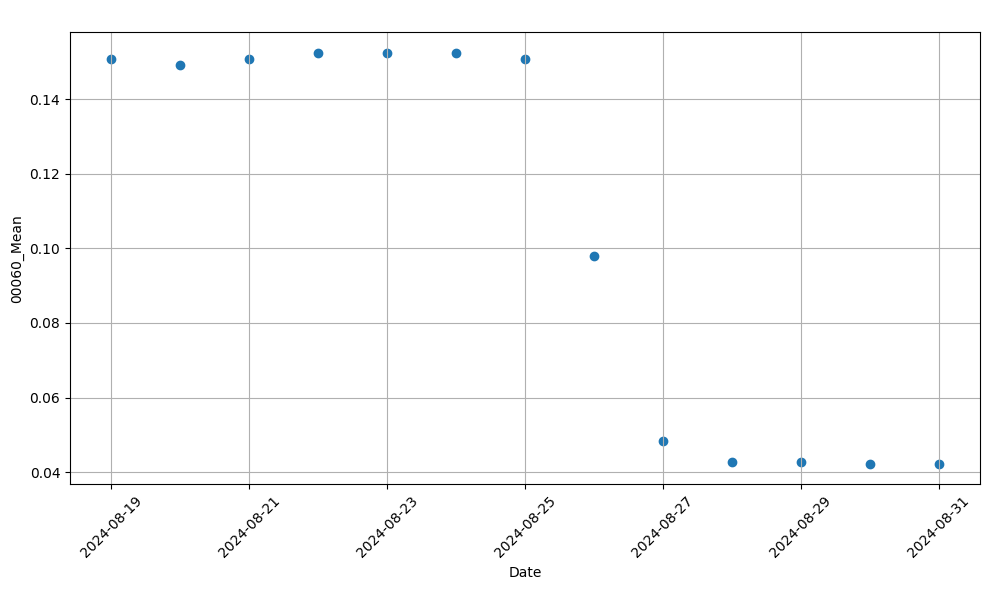

In [28]:
print(summer_df.info())
print(summer_df.head())

# --- prep ---
#summer_df['Date'] = summer_df.to_datetime( subset_rows['Date'])      # make sure Date is datetime
summer_df = summer_df.sort_values('Date').reset_index(drop=True)

# --- locate the peak bias ---
idx_peak   = summer_df['bias'].idxmin()             # row index of the max bias
date_peak  = summer_df.at[idx_peak, 'Date']         # corresponding date

# ------- OPTION 1: ±12 *days* around that date -------
start_day  = date_peak - pd.Timedelta(days=12)
end_day    = date_peak + pd.Timedelta(days=12)

subset_days = summer_df[(summer_df['Date'] >= start_day) & ( summer_df['Date'] <= end_day)].copy()

# ------- OPTION 2: ±12 *rows* around that row index -------
start_idx  = max(idx_peak - 12, 0)
end_idx    = min(idx_peak + 12, len(df) - 1)

subset_rows = summer_df.loc[start_idx : end_idx].copy()
subset_rows


# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows['bias'])

# Customizing the plot
plt.title('Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Bias')
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = 'tmean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00010_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00060_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030